# Imports

In [1573]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [1574]:
train_df = pd.read_csv('./Train_Data.csv')
test_df = pd.read_csv('./Test_Data.csv')

# EDA

In [1575]:
def h(content): # Function for displaying content in HTML/Markdown format
    display(HTML(content)) # display content in HTML/Markdown format
    

def _desc(data, col, label): # Column description in a given dataset
    d0 = data.describe().reset_index() # Basic description (mean, std, min, max etc...) for a column
    d0.columns = [col, label]
    # Append column's unique values, number of NaNs and NaNs share and return it
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \


def desc1(col): # Function for column description
    d0 = _desc(train_df[col], col, 'Train') # Description for column in Train dataset
    d1 = _desc(train_df.loc[train_df['Survived_1_year'] == 1, col], col, 'Train Survived') # Description for column in Train dataset where Survived_1_year is True
    d2 = _desc(train_df.loc[train_df['Survived_1_year'] == 0, col], col, 'Train Didn\t Survive') # Description for column in Train dataset where Survived_1_year is False
    d3 = _desc(test_df[col], col, 'Test') # Description for column in Test dataset
    n_public = int(test_df.shape[0] * 0.2) # 20% of test data
    d4 = _desc(test_df.loc[:n_public, col], col, 'Test public') # Description for column in Test public (20%)
    d5 = _desc(test_df.loc[n_public:, col], col, 'Test private') # Description for column in Test private (80%)
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5) # Merge all descriptive Datasets together
    display(dd) # Display the resulting descriptive Dataset

    if col not in ['Patient_ID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        # Size, mean and sum results for Survived column grouped by a given column in dataset
        d0 = train_df[['Survived_1_year',col]].fillna(-999).groupby(col)['Survived_1_year'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        # Count results for Patient_ID column grouped by a given column in dataset
        d1 = train_df[['Patient_ID',col]].fillna(-999).groupby(col)['Patient_ID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N) # Merge d0 and d1 results together
        dd = dd.rename({'size':'Count in train_df (desc)','mean':'Mean target','sum':'Sum target','Patient_ID':'Count in train_df'}, axis=1) # Renaming dataframe columns
        display(dd) # Display the resulting descriptive Dataset
        
        h('<b>Biggest sum values in train (NaN = -999):</b>')
        # Biggest values for d0 and d1 combined
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','Patient_ID':'Count in test'}, axis=1) # Renaming dataframe columns
        display(dd) # Display the resulting descriptive Dataset


def hist1(col): # Function for histogram for a given column in Train and Test datasets
    plt.figure(figsize=(15, 3)) # Size of a plot
    plt.subplot(121) # Number of rows, number of columns and index for a subplot
    plt.hist(train_df[col], bins=15); # Histogram for a given column
    plt.title('Train histogram: ' + col); # Title for a histogram
    plt.subplot(122) # Number of rows, number of columns and index for a subplot
    plt.hist(test_df[col], bins=15); # Histogram for a given column
    plt.title('Test histogram: ' + col); # Title for a histogram
    plt.show() # Show histograms


def corr1(col): # Function for the most correlated values for the given column - Correlation
    N = None #10000
    num_vars = [f for f in train_df.columns if train_df[f].dtype != 'object'] # List of all numeric columns
    trx = train_df.head(N) if N is not None else train_df.copy() # Temporary dataframe for the correlation results
    # The most correlated columns with the given column (Only numeric columns)
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)]) # Final correlation results to dataframe
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))


def numeric(col): # EDA for numeric columns
    hist1(col) # Histogram
    desc1(col) # Description
    corr1(col) # Correlation


def categorical(col): # EDA for categorical columns
    desc1(col) # Description


def proc(col): # Function for running eda
    if col not in ['Patient_ID', 'ID_Patient_Care_Situation', 'Survived_1_year']:
        h('<h3 id="c_' + col + '">' + col + '</h3>')
        categorical(col) if train_df[col].dtype == 'object' else numeric(col) # Make EDA for a column

# Navigation
included_cols = list(train_df.columns.values)
# Shape of dataset
h('Dataframe shape: <b>' + str(train_df.shape) + '</b>')
# Preview
h('Dataframe preview:')
display(train_df.head(10))

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
0,22374,8,3333,DX6,56,18.479385,YES,URBAN,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
1,18164,5,5740,DX2,36,22.945566,YES,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,6283,23,10446,DX6,48,27.510027,YES,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,5339,51,12011,DX1,5,19.130976,NO,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,33012,0,12513,NaN,128,1.348400,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
5,10808,45,7977,DX6,47,26.155120,YES,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
6,5138,52,5296,DX3,53,19.103244,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
7,17265,9,5947,DX5,3,18.126976,NO,URBAN,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
8,24349,47,6585,DX4,62,25.074482,NO,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
9,1647,17,10190,DX6,46,17.663877,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1


# Survived_1_year EDA

In [1576]:
# Survived_1_year EDA
COL = 'Survived_1_year'
h('<h2 id="c_' + COL + '">' + COL)
h('This is target column.')
# True and False counts in Survived_1_year column
trx = train_df['Survived_1_year'].value_counts().reset_index().rename({'index':'Value','Survived_1_year':'Count'}, axis=1)
# Percentage of True and False in Survived_1_year column
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 6)
display(trx) # Display the resulting stats
corr1(COL) # Most correlated columns with Survived_1_year column

,Value,Count,Share
0,1,14603,0.632247
1,0,8494,0.367753


,Column,Correlation with Survived_1_year
0,Survived_1_year,1.000000
1,E,0.021527
2,Z,0.018910
3,F,0.004073
4,Patient_ID,-0.004214
5,Diagnosed_Condition,-0.004450
9,A,-0.049886
10,Patient_Age,-0.074934
11,Number_of_prev_cond,-0.081159
12,D,-0.105710


# EDA for other columns

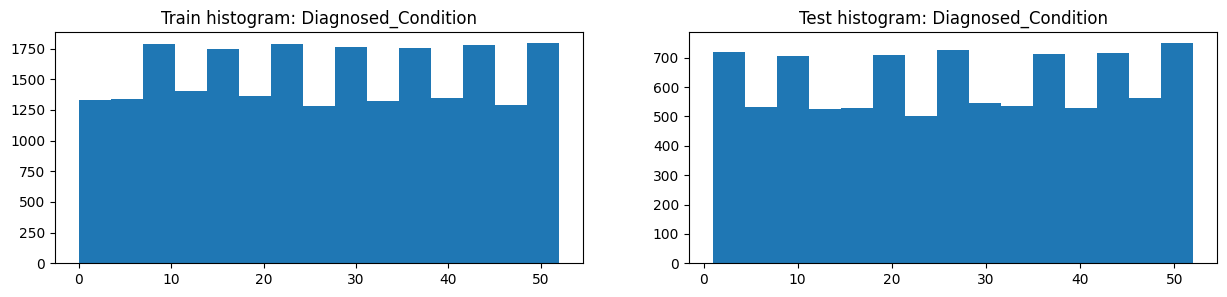

,Diagnosed_Condition,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,23097.000000,14603.000000,8494.000000,9303.000000,1861.000000,7443.000000
1,mean,26.413127,26.362117,26.500824,26.680426,26.347125,26.761790
2,std,15.030865,15.914550,13.376300,15.097842,15.055913,15.108123
3,min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
4,25%,13.000000,12.000000,17.000000,14.000000,13.000000,14.000000
5,50%,26.000000,26.000000,26.000000,27.000000,26.000000,27.000000
6,75%,39.000000,41.000000,35.000000,40.000000,39.000000,40.000000
7,max,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
8,unique values,53.000000,53.000000,52.000000,52.000000,52.000000,52.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,Diagnosed_Condition,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,11,489,0.707566,346,489
1,12,483,0.685300,331,483
2,49,479,0.728601,349,479
3,7,471,0.709130,334,471
4,52,469,0.656716,308,469
5,43,469,0.746269,350,469
6,18,468,0.675214,316,468
7,36,466,0.721030,336,466
8,17,461,0.724512,334,461
9,40,460,0.730435,336,460


,Diagnosed_Condition,Count in train,Mean target,Sum target (desc),Count in test
0,43,469,0.746269,350,469
1,49,479,0.728601,349,479
2,11,489,0.707566,346,489
3,36,466,0.721030,336,466
4,40,460,0.730435,336,460
5,8,460,0.728261,335,460
6,17,461,0.724512,334,461
7,1,459,0.727669,334,459
8,7,471,0.709130,334,471
9,46,448,0.743304,333,448


,Column,Correlation with Diagnosed_Condition
0,Diagnosed_Condition,1.000000
1,Patient_ID,0.008315
2,Patient_Body_Mass_Index,0.008305
3,E,0.007902
4,F,0.005931
5,A,0.004940
9,Survived_1_year,-0.004450
10,ID_Patient_Care_Situation,-0.007446
11,D,-0.007843
12,Patient_Age,-0.008971


,Treated_with_drugs,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,23084,14590,8494,9303,1861,7443
1,unique,32,32,31,32,32,32
2,top,DX6,DX6,DX6,DX6,DX6,DX6
3,freq,8606,3663,4943,3462,679,2783
4,unique values,33,33,31,32,32,32
5,NaNs,13,13,0,0,0,0
6,NaNs share,0.0006,0.0009,0.0,0.0,0.0,0.0


,Treated_with_drugs,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,DX6,8606,0.425633,3663,8606
1,DX5,1909,0.816134,1558,1909
2,DX2,1904,0.711660,1355,1904
3,DX1,1835,0.749319,1375,1835
4,DX3,1830,0.738251,1351,1830
5,DX4,1792,0.694196,1244,1792
6,DX1 DX2,448,0.654018,293,448
7,DX3 DX4,448,0.743304,333,448
8,DX1 DX3,424,0.813679,345,424
9,DX4 DX5,423,0.780142,330,423


,Treated_with_drugs,Count in train,Mean target,Sum target (desc),Count in test
0,DX6,8606,0.425633,3663,8606
1,DX5,1909,0.816134,1558,1909
2,DX1,1835,0.749319,1375,1835
3,DX2,1904,0.711660,1355,1904
4,DX3,1830,0.738251,1351,1830
5,DX4,1792,0.694196,1244,1792
6,DX1 DX5,402,0.883085,355,402
7,DX3 DX5,407,0.850123,346,407
8,DX1 DX3,424,0.813679,345,424
9,DX3 DX4,448,0.743304,333,448


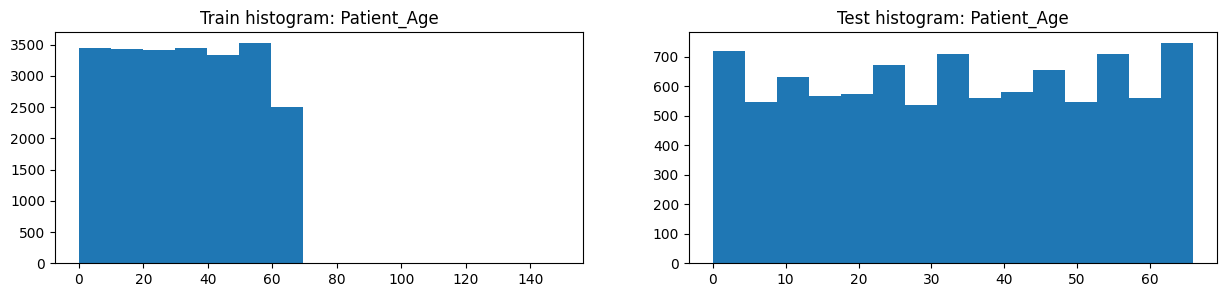

,Patient_Age,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,23097.000000,14603.000000,8494.000000,9303.000000,1861.000000,7443.000000
1,mean,33.209768,32.092515,35.130563,33.249059,33.168189,33.264813
2,std,19.549882,18.989447,20.335721,19.477920,19.361812,19.510590
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,16.000000,15.000000,18.000000,17.000000,17.000000,17.000000
5,50%,33.000000,31.000000,36.000000,33.000000,33.000000,33.000000
6,75%,50.000000,49.000000,53.000000,50.000000,50.000000,50.000000
7,max,149.000000,149.000000,66.000000,66.000000,66.000000,66.000000
8,unique values,78.000000,78.000000,67.000000,67.000000,67.000000,67.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,Patient_Age,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,31,401,0.660848,265,401
1,19,395,0.663291,262,395
2,64,394,0.403553,159,394
3,36,393,0.653944,257,393
4,0,392,0.551020,216,392
5,22,390,0.638462,249,390
6,57,382,0.641361,245,382
7,13,380,0.681579,259,380
8,51,376,0.638298,240,376
9,15,376,0.630319,237,376


,Patient_Age,Count in train,Mean target,Sum target (desc),Count in test
0,9,368,0.801630,295,368
1,11,358,0.810056,290,358
2,8,345,0.834783,288,345
3,31,401,0.660848,265,401
4,19,395,0.663291,262,395
5,13,380,0.681579,259,380
6,36,393,0.653944,257,393
7,29,365,0.698630,255,365
8,50,364,0.700549,255,364
9,22,390,0.638462,249,390


,Column,Correlation with Patient_Age
0,Patient_Age,1.000000
1,Z,0.117190
2,Patient_ID,0.014015
3,F,0.006697
4,D,0.003471
5,ID_Patient_Care_Situation,0.000304
9,C,-0.012989
10,B,-0.013554
11,Number_of_prev_cond,-0.019371
12,A,-0.027559


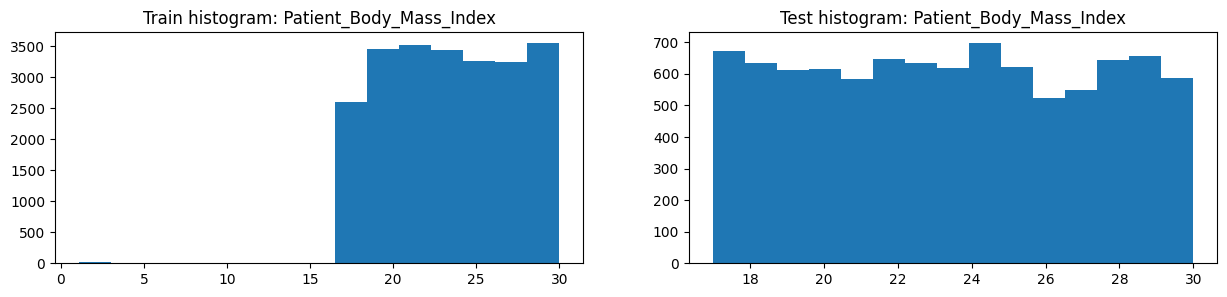

,Patient_Body_Mass_Index,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,23097.000000,14603.000000,8494.000000,9303.000000,1861.000000,7443.000000
1,mean,23.454820,23.100994,24.063122,23.429321,23.462221,23.420429
2,std,3.807661,3.474236,4.253124,3.769305,3.737673,3.777561
3,min,1.089300,1.089300,17.000336,17.000695,17.012532,17.000695
4,25%,20.205550,20.298848,19.900611,20.166849,20.160684,20.166849
5,50%,23.386199,22.961101,24.573334,23.392495,23.589753,23.357759
6,75%,26.788154,25.784127,28.060247,26.726929,26.683622,26.730785
7,max,29.999579,29.999579,29.999579,29.999579,29.999579,29.999579
8,unique values,10570.000000,8183.000000,5531.000000,6418.000000,1727.000000,5470.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,Patient_Body_Mass_Index,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,27.636765,9,0.333333,3,9
1,21.593501,8,0.250000,2,8
2,19.097499,8,1.000000,8,8
3,27.396334,8,0.750000,6,8
4,28.697330,8,0.875000,7,8
5,28.548780,8,0.375000,3,8
6,21.745004,8,0.625000,5,8
7,22.437644,8,1.000000,8,8
8,24.781176,7,0.714286,5,7
9,29.188086,7,0.571429,4,7


,Patient_Body_Mass_Index,Count in train,Mean target,Sum target (desc),Count in test
0,19.097499,8,1.000,8,8
1,22.437644,8,1.000,8,8
2,28.697330,8,0.875,7,8
3,26.835366,6,1.000,6,6
4,24.297237,6,1.000,6,6
5,25.835926,6,1.000,6,6
6,20.351504,6,1.000,6,6
7,20.261617,6,1.000,6,6
8,19.656056,6,1.000,6,6
9,20.238128,6,1.000,6,6


,Column,Correlation with Patient_Body_Mass_Index
0,Patient_Body_Mass_Index,1.000000
1,A,0.019681
2,Diagnosed_Condition,0.008305
3,B,0.002384
4,E,-0.003661
5,Patient_Age,-0.006560
9,F,-0.015598
10,C,-0.016850
11,Patient_ID,-0.023189
12,Survived_1_year,-0.121844


,Patient_Smoker,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,23097,14603,8494,9303,1861,7443
1,unique,3,3,2,2,2,2
2,top,NO,NO,YES,NO,NO,NO
3,freq,13246,9767,5015,5333,1047,4287
4,unique values,3,3,2,2,2,2
5,NaNs,0,0,0,0,0,0
6,NaNs share,0.0,0.0,0.0,0.0,0.0,0.0


,Patient_Smoker,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,NO,13246,0.737355,9767,13246
1,YES,9838,0.490242,4823,9838
2,Cannot say,13,1.000000,13,13


,Patient_Smoker,Count in train,Mean target,Sum target (desc),Count in test
0,NO,13246,0.737355,9767,13246
1,YES,9838,0.490242,4823,9838
2,Cannot say,13,1.000000,13,13


,Patient_Rural_Urban,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,23097,14603,8494,9303,1861,7443
1,unique,2,2,2,2,2,2
2,top,RURAL,RURAL,RURAL,RURAL,RURAL,RURAL
3,freq,16134,10777,5357,6502,1304,5198
4,unique values,2,2,2,2,2,2
5,NaNs,0,0,0,0,0,0
6,NaNs share,0.0,0.0,0.0,0.0,0.0,0.0


,Patient_Rural_Urban,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,RURAL,16134,0.667968,10777,16134
1,URBAN,6963,0.549476,3826,6963


,Patient_Rural_Urban,Count in train,Mean target,Sum target (desc),Count in test
0,RURAL,16134,0.667968,10777,16134
1,URBAN,6963,0.549476,3826,6963


,Patient_mental_condition,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,23097,14603,8494,9303,1861,7443
1,unique,1,1,1,1,1,1
2,top,Stable,Stable,Stable,Stable,Stable,Stable
3,freq,23097,14603,8494,9303,1861,7443
4,unique values,1,1,1,1,1,1
5,NaNs,0,0,0,0,0,0
6,NaNs share,0.0,0.0,0.0,0.0,0.0,0.0


,Patient_mental_condition,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,Stable,23097,0.632247,14603,23097


,Patient_mental_condition,Count in train,Mean target,Sum target (desc),Count in test
0,Stable,23097,0.632247,14603,23097


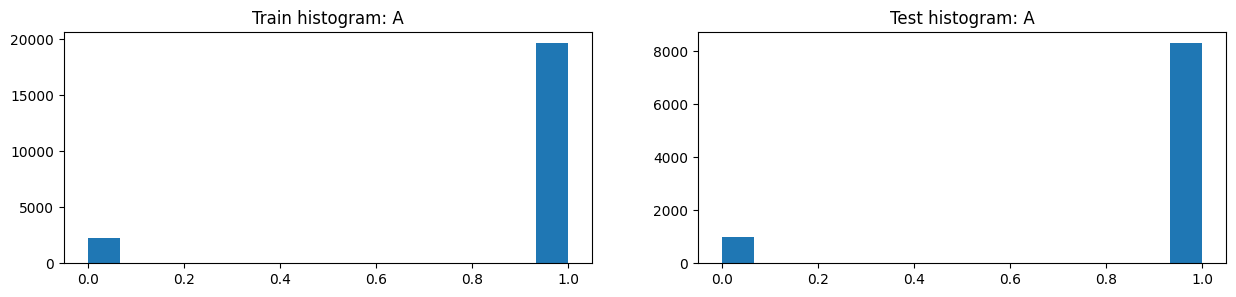

,A,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.000000,9303.000000,1861.000000,7443.000000
1,mean,0.897905,0.886196,0.917388,0.893260,0.898442,0.891979
2,std,0.302780,0.317585,0.275312,0.308799,0.302148,0.310428
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,unique values,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000
9,NaNs,1235.000000,948.000000,287.000000,0.000000,0.000000,0.000000


,A,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,1.0,19630,0.616454,12101,19630
1,0.0,2232,0.696237,1554,2232
2,-999.0,1235,0.767611,948,1235


,A,Count in train,Mean target,Sum target (desc),Count in test
0,1.0,19630,0.616454,12101,19630
1,0.0,2232,0.696237,1554,2232
2,-999.0,1235,0.767611,948,1235


,Column,Correlation with A
0,A,1.000000
1,Number_of_prev_cond,0.170448
2,Patient_Body_Mass_Index,0.019681
3,Diagnosed_Condition,0.004940
4,ID_Patient_Care_Situation,0.004557
5,Patient_ID,-0.005371
9,B,-0.063683
10,Z,-0.072338
11,D,-0.076064
12,C,-0.089832


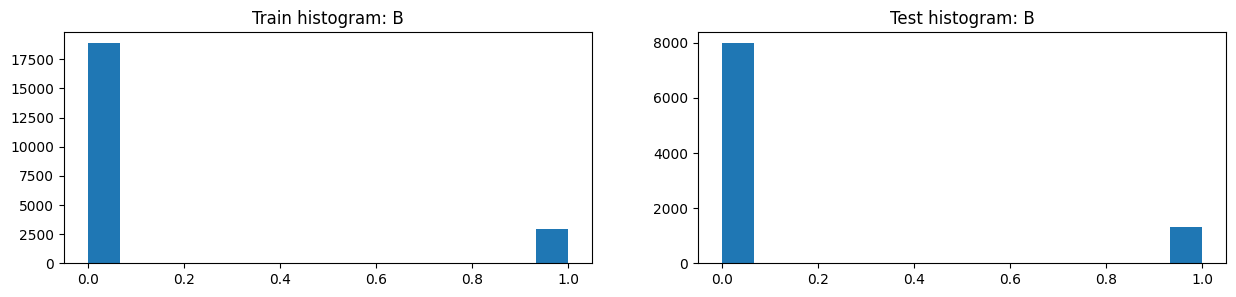

,B,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.000000,9303.000000,1861.000000,7443.000000
1,mean,0.136355,0.123105,0.158401,0.142320,0.145083,0.141610
2,std,0.343173,0.328570,0.365139,0.349396,0.352279,0.348673
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,unique values,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000
9,NaNs,1235.000000,948.000000,287.000000,0.000000,0.000000,0.000000


,B,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,0.0,18881,0.634183,11974,18881
1,1.0,2981,0.563905,1681,2981
2,-999.0,1235,0.767611,948,1235


,B,Count in train,Mean target,Sum target (desc),Count in test
0,0.0,18881,0.634183,11974,18881
1,1.0,2981,0.563905,1681,2981
2,-999.0,1235,0.767611,948,1235


,Column,Correlation with B
0,B,1.000000
1,Number_of_prev_cond,0.392773
2,ID_Patient_Care_Situation,0.005110
3,Diagnosed_Condition,0.003936
4,Patient_Body_Mass_Index,0.002384
5,D,-0.002050
9,F,-0.016013
10,E,-0.017804
11,C,-0.021175
12,Survived_1_year,-0.049805


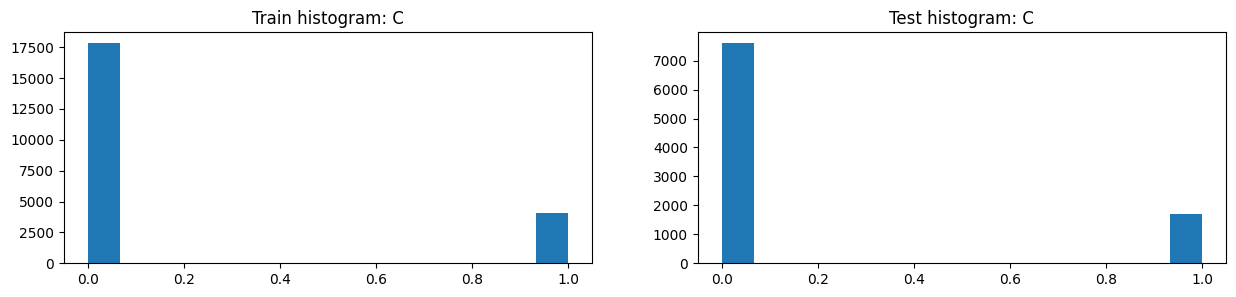

,C,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.000000,9303.000000,1861.000000,7443.000000
1,mean,0.185070,0.175027,0.201779,0.183167,0.178936,0.184200
2,std,0.388363,0.380005,0.401353,0.386824,0.383402,0.387673
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,unique values,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000
9,NaNs,1235.000000,948.000000,287.000000,0.000000,0.000000,0.000000


,C,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,0.0,17816,0.632297,11265,17816
1,1.0,4046,0.590707,2390,4046
2,-999.0,1235,0.767611,948,1235


,C,Count in train,Mean target,Sum target (desc),Count in test
0,0.0,17816,0.632297,11265,17816
1,1.0,4046,0.590707,2390,4046
2,-999.0,1235,0.767611,948,1235


,Column,Correlation with C
0,C,1.000000
1,Number_of_prev_cond,0.445349
2,ID_Patient_Care_Situation,0.010724
3,D,0.007528
4,F,0.000903
5,Diagnosed_Condition,-0.002826
9,Patient_Body_Mass_Index,-0.016850
10,B,-0.021175
11,E,-0.026294
12,Survived_1_year,-0.033356


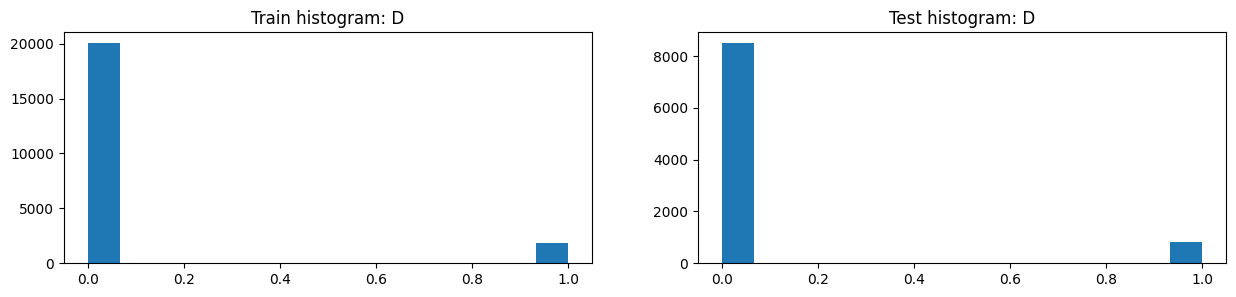

,D,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.000000,9303.000000,1861.000000,7443.000000
1,mean,0.083615,0.060930,0.121360,0.087284,0.082751,0.088405
2,std,0.276817,0.239211,0.326565,0.282265,0.275580,0.283902
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,unique values,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000
9,NaNs,1235.000000,948.000000,287.000000,0.000000,0.000000,0.000000


,D,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,0.0,20034,0.640062,12823,20034
1,1.0,1828,0.455142,832,1828
2,-999.0,1235,0.767611,948,1235


,D,Count in train,Mean target,Sum target (desc),Count in test
0,0.0,20034,0.640062,12823,20034
1,-999.0,1235,0.767611,948,1235
2,1.0,1828,0.455142,832,1828


,Column,Correlation with D
0,D,1.000000
1,Number_of_prev_cond,0.320736
2,C,0.007528
3,Patient_Age,0.003471
4,B,-0.002050
5,Patient_ID,-0.004678
9,Patient_Body_Mass_Index,-0.008383
10,F,-0.009650
11,E,-0.013478
12,A,-0.076064


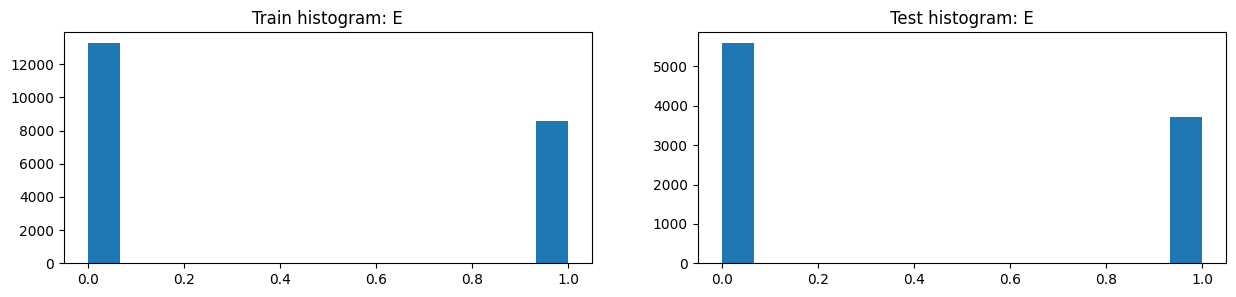

,E,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.000000,9303.000000,1861.000000,7443.000000
1,mean,0.393239,0.401391,0.379676,0.399441,0.399785,0.399436
2,std,0.488480,0.490198,0.485336,0.489810,0.489986,0.489815
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,unique values,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000
9,NaNs,1235.000000,948.000000,287.000000,0.000000,0.000000,0.000000


,E,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,0.0,13265,0.616208,8174,13265
1,1.0,8597,0.637548,5481,8597
2,-999.0,1235,0.767611,948,1235


,E,Count in train,Mean target,Sum target (desc),Count in test
0,0.0,13265,0.616208,8174,13265
1,1.0,8597,0.637548,5481,8597
2,-999.0,1235,0.767611,948,1235


,Column,Correlation with E
0,E,1.000000
1,Number_of_prev_cond,0.541840
2,Survived_1_year,0.021527
3,Diagnosed_Condition,0.007902
4,Patient_ID,0.000746
5,ID_Patient_Care_Situation,0.000575
9,D,-0.013478
10,B,-0.017804
11,Z,-0.019637
12,C,-0.026294


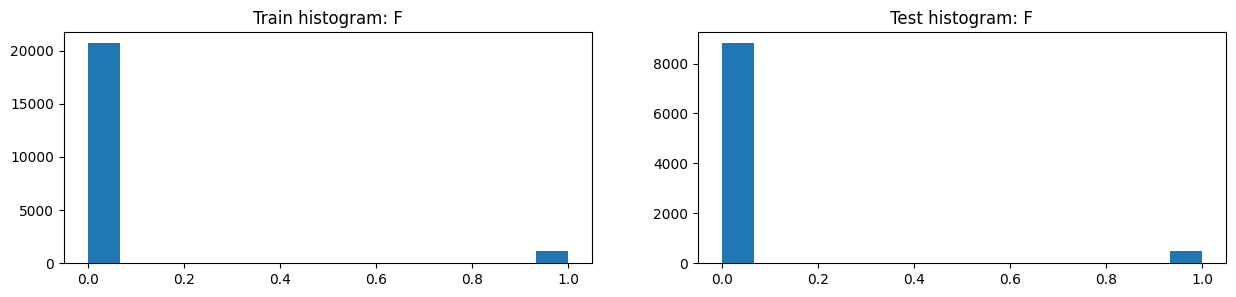

,F,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.000000,9303.000000,1861.000000,7443.000000
1,mean,0.053700,0.054412,0.052516,0.052886,0.054272,0.052533
2,std,0.225431,0.226838,0.223079,0.223818,0.226614,0.223113
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,unique values,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000
9,NaNs,1235.000000,948.000000,287.000000,0.000000,0.000000,0.000000


,F,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,0.0,20688,0.624130,12912,20688
1,-999.0,1235,0.767611,948,1235
2,1.0,1174,0.632879,743,1174


,F,Count in train,Mean target,Sum target (desc),Count in test
0,0.0,20688,0.624130,12912,20688
1,-999.0,1235,0.767611,948,1235
2,1.0,1174,0.632879,743,1174


,Column,Correlation with F
0,F,1.000000
1,Number_of_prev_cond,0.257609
2,Patient_ID,0.007838
3,ID_Patient_Care_Situation,0.007779
4,Patient_Age,0.006697
5,Diagnosed_Condition,0.005931
9,Z,-0.005811
10,D,-0.009650
11,Patient_Body_Mass_Index,-0.015598
12,B,-0.016013


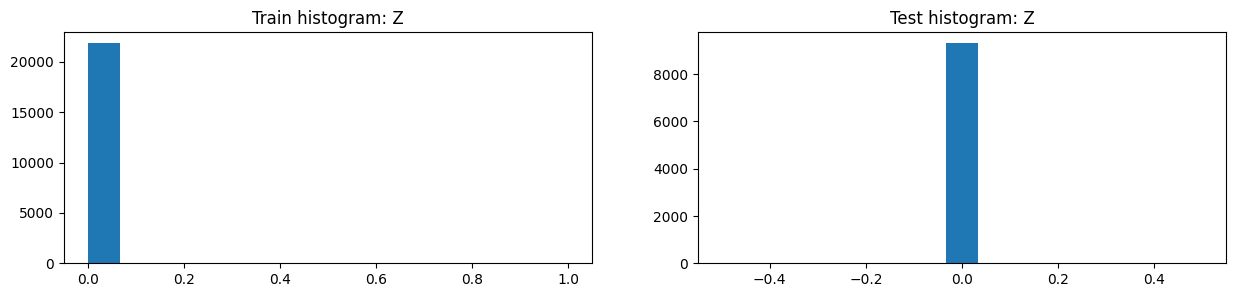

,Z,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.0000,9303.0,1861.0,7443.0
1,mean,0.000595,0.000952,0.0000,0.0,0.0,0.0
2,std,0.024379,0.030841,0.0000,0.0,0.0,0.0
3,min,0.000000,0.000000,0.0000,0.0,0.0,0.0
4,25%,0.000000,0.000000,0.0000,0.0,0.0,0.0
5,50%,0.000000,0.000000,0.0000,0.0,0.0,0.0
6,75%,0.000000,0.000000,0.0000,0.0,0.0,0.0
7,max,1.000000,1.000000,0.0000,0.0,0.0,0.0
8,unique values,3.000000,3.000000,2.0000,1.0,1.0,1.0
9,NaNs,1235.000000,948.000000,287.0000,0.0,0.0,0.0


,Z,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,0.0,21849,0.624376,13642,21849
1,-999.0,1235,0.767611,948,1235
2,1.0,13,1.000000,13,13


,Z,Count in train,Mean target,Sum target (desc),Count in test
0,0.0,21849,0.624376,13642,21849
1,-999.0,1235,0.767611,948,1235
2,1.0,13,1.000000,13,13


,Column,Correlation with Z
0,Z,1.000000
1,Patient_Age,0.117190
2,Patient_ID,0.042348
3,ID_Patient_Care_Situation,0.042146
4,Survived_1_year,0.018910
5,F,-0.005811
9,E,-0.019637
10,Number_of_prev_cond,-0.023765
11,Diagnosed_Condition,-0.042806
12,A,-0.072338


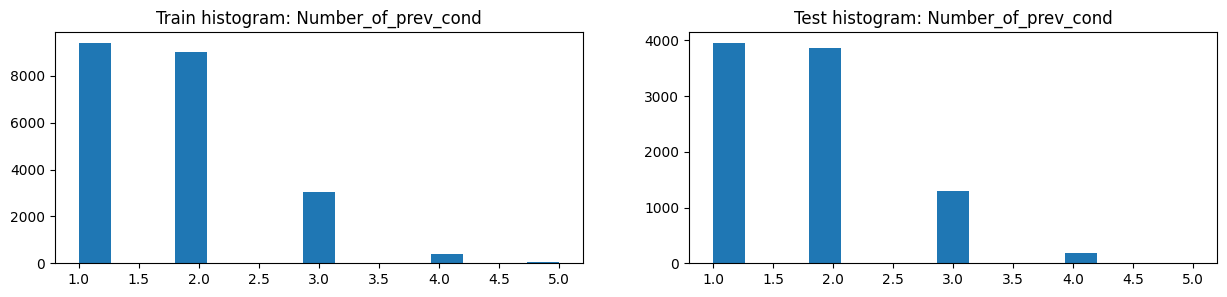

,Number_of_prev_cond,Train,Train Survived,Train Didn\t Survive,Test,Test public,Test private
0,count,21862.000000,13655.000000,8207.000000,9303.000000,1861.000000,7443.000000
1,mean,1.750480,1.702014,1.831120,1.758358,1.759269,1.758162
2,std,0.770311,0.728809,0.828591,0.771230,0.768378,0.771946
3,min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
6,75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
7,max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
8,unique values,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000
9,NaNs,1235.000000,948.000000,287.000000,0.000000,0.000000,0.000000


,Number_of_prev_cond,Count in train_df (desc),Mean target,Sum target,Count in train_df
0,1.0,9386,0.651076,6111,9386
1,2.0,9016,0.627329,5656,9016
2,3.0,3026,0.573695,1736,3026
3,-999.0,1235,0.767611,948,1235
4,4.0,397,0.377834,150,397
5,5.0,37,0.054054,2,37


,Number_of_prev_cond,Count in train,Mean target,Sum target (desc),Count in test
0,1.0,9386,0.651076,6111,9386
1,2.0,9016,0.627329,5656,9016
2,3.0,3026,0.573695,1736,3026
3,-999.0,1235,0.767611,948,1235
4,4.0,397,0.377834,150,397
5,5.0,37,0.054054,2,37


,Column,Correlation with Number_of_prev_cond
0,Number_of_prev_cond,1.000000
1,E,0.541840
2,C,0.445349
3,B,0.392773
4,D,0.320736
5,F,0.257609
9,Patient_ID,-0.008344
10,Patient_Body_Mass_Index,-0.014036
11,Patient_Age,-0.019371
12,Z,-0.023765


In [1577]:
# EDA for other columns
for col in list(train_df.columns.values):
    proc(col) # Run EDA

# Preprocessing

In [1578]:
train_df.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
0,22374,8,3333,DX6,56,18.479385,YES,URBAN,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
1,18164,5,5740,DX2,36,22.945566,YES,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,6283,23,10446,DX6,48,27.510027,YES,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,5339,51,12011,DX1,5,19.130976,NO,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,33012,0,12513,NaN,128,1.348400,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1


In [1579]:
# ~Non-continuous values 
scaler = MinMaxScaler()
test_df[['Diagnosed_Condition', 'Patient_Age', 'Patient_Body_Mass_Index']] = scaler.fit_transform(test_df[['Diagnosed_Condition', 'Patient_Age', 'Patient_Body_Mass_Index']])
train_df[['Diagnosed_Condition', 'Patient_Age', 'Patient_Body_Mass_Index']] = scaler.fit_transform(train_df[['Diagnosed_Condition', 'Patient_Age', 'Patient_Body_Mass_Index']])

In [1580]:
encoder = LabelEncoder()
test_df['Treated_with_drugs'] = encoder.fit_transform(test_df['Treated_with_drugs'])
test_df['Patient_Smoker'] = encoder.fit_transform(test_df['Patient_Smoker'])
test_df['Patient_Rural_Urban'] = encoder.fit_transform(test_df['Patient_Rural_Urban'])
train_df['Treated_with_drugs'] = encoder.fit_transform(train_df['Treated_with_drugs'])
train_df['Patient_Smoker'] = encoder.fit_transform(train_df['Patient_Smoker'])
train_df['Patient_Rural_Urban'] = encoder.fit_transform(train_df['Patient_Rural_Urban'])

In [1581]:
# Share of NaNs is 5%, dropping NaNs
train_df.dropna(axis=0, inplace=True)
test_df.dropna(axis=0, inplace=True)

In [1582]:
# Some Feature Engineering (Train Data)
train_df['A+B'] = train_df['A'] + train_df['B']
train_df['A+C'] = train_df['A'] + train_df['C']
train_df['A+D'] = train_df['A'] + train_df['D']
train_df['A+E'] = train_df['A'] + train_df['E']
train_df['A+F'] = train_df['A'] + train_df['F']
train_df['A+Z'] = train_df['A'] + train_df['Z']
train_df['B+C'] = train_df['B'] + train_df['C']
train_df['B+D'] = train_df['B'] + train_df['D']
train_df['B+E'] = train_df['B'] + train_df['E']
train_df['B+F'] = train_df['B'] + train_df['F']
train_df['B+Z'] = train_df['B'] + train_df['Z']
train_df['C+D'] = train_df['C'] + train_df['D']
train_df['C+E'] = train_df['C'] + train_df['E']
train_df['C+F'] = train_df['C'] + train_df['F']
train_df['C+Z'] = train_df['C'] + train_df['Z']
train_df['D+E'] = train_df['D'] + train_df['E']
train_df['D+F'] = train_df['D'] + train_df['F']
train_df['D+Z'] = train_df['D'] + train_df['Z']
train_df['E+F'] = train_df['E'] + train_df['F']
train_df['E+Z'] = train_df['E'] + train_df['Z']
train_df['F+Z'] = train_df['F'] + train_df['Z']

train_df['A-B'] = train_df['A'] - train_df['B']
train_df['A-C'] = train_df['A'] - train_df['C']
train_df['A-D'] = train_df['A'] - train_df['D']
train_df['A-E'] = train_df['A'] - train_df['E']
train_df['A-F'] = train_df['A'] - train_df['F']
train_df['A-Z'] = train_df['A'] - train_df['Z']
train_df['B-A'] = train_df['B'] - train_df['A']
train_df['B-C'] = train_df['B'] - train_df['C']
train_df['B-D'] = train_df['B'] - train_df['D']
train_df['B-E'] = train_df['B'] - train_df['E']
train_df['B-F'] = train_df['B'] - train_df['F']
train_df['B-Z'] = train_df['B'] - train_df['Z']
train_df['C-A'] = train_df['C'] - train_df['A']
train_df['C-B'] = train_df['C'] - train_df['B']
train_df['C-D'] = train_df['C'] - train_df['D']
train_df['C-E'] = train_df['C'] - train_df['E']
train_df['C-F'] = train_df['C'] - train_df['F']
train_df['C-Z'] = train_df['C'] - train_df['Z']
train_df['D-A'] = train_df['D'] - train_df['A']
train_df['D-B'] = train_df['D'] - train_df['B']
train_df['D-C'] = train_df['D'] - train_df['C']
train_df['D-E'] = train_df['D'] - train_df['E']
train_df['D-F'] = train_df['D'] - train_df['F']
train_df['D-Z'] = train_df['D'] - train_df['Z']
train_df['E-A'] = train_df['E'] - train_df['A']
train_df['E-B'] = train_df['E'] - train_df['B']
train_df['E-C'] = train_df['E'] - train_df['C']
train_df['E-D'] = train_df['E'] - train_df['D']
train_df['E-F'] = train_df['E'] - train_df['F']
train_df['E-Z'] = train_df['E'] - train_df['Z']
train_df['F-A'] = train_df['F'] - train_df['A']
train_df['F-B'] = train_df['F'] - train_df['B']
train_df['F-C'] = train_df['F'] - train_df['C']
train_df['F-D'] = train_df['F'] - train_df['D']
train_df['F-E'] = train_df['F'] - train_df['E']
train_df['F-Z'] = train_df['F'] - train_df['Z']

train_df['A*B'] = train_df['A'] * train_df['B']
train_df['A*C'] = train_df['A'] * train_df['C']
train_df['A*D'] = train_df['A'] * train_df['D']
train_df['A*E'] = train_df['A'] * train_df['E']
train_df['A*F'] = train_df['A'] * train_df['F']
train_df['A*Z'] = train_df['A'] * train_df['Z']
train_df['B*C'] = train_df['B'] * train_df['C']
train_df['B*D'] = train_df['B'] * train_df['D']
train_df['B*E'] = train_df['B'] * train_df['E']
train_df['B*F'] = train_df['B'] * train_df['F']
train_df['B*Z'] = train_df['B'] * train_df['Z']
train_df['C*D'] = train_df['C'] * train_df['D']
train_df['C*E'] = train_df['C'] * train_df['E']
train_df['C*F'] = train_df['C'] * train_df['F']
train_df['C*Z'] = train_df['C'] * train_df['Z']
train_df['D*E'] = train_df['D'] * train_df['E']
train_df['D*F'] = train_df['D'] * train_df['F']
train_df['D*Z'] = train_df['D'] * train_df['Z']
train_df['E*F'] = train_df['E'] * train_df['F']
train_df['E*Z'] = train_df['E'] * train_df['Z']
train_df['F*Z'] = train_df['F'] * train_df['Z']

In [1583]:
# Some Feature Engineering (Test Data)
test_df['A+B'] = test_df['A'] + test_df['B']
test_df['A+C'] = test_df['A'] + test_df['C']
test_df['A+D'] = test_df['A'] + test_df['D']
test_df['A+E'] = test_df['A'] + test_df['E']
test_df['A+F'] = test_df['A'] + test_df['F']
test_df['A+Z'] = test_df['A'] + test_df['Z']
test_df['B+C'] = test_df['B'] + test_df['C']
test_df['B+D'] = test_df['B'] + test_df['D']
test_df['B+E'] = test_df['B'] + test_df['E']
test_df['B+F'] = test_df['B'] + test_df['F']
test_df['B+Z'] = test_df['B'] + test_df['Z']
test_df['C+D'] = test_df['C'] + test_df['D']
test_df['C+E'] = test_df['C'] + test_df['E']
test_df['C+F'] = test_df['C'] + test_df['F']
test_df['C+Z'] = test_df['C'] + test_df['Z']
test_df['D+E'] = test_df['D'] + test_df['E']
test_df['D+F'] = test_df['D'] + test_df['F']
test_df['D+Z'] = test_df['D'] + test_df['Z']
test_df['E+F'] = test_df['E'] + test_df['F']
test_df['E+Z'] = test_df['E'] + test_df['Z']
test_df['F+Z'] = test_df['F'] + test_df['Z']

test_df['A-B'] = test_df['A'] - test_df['B']
test_df['A-C'] = test_df['A'] - test_df['C']
test_df['A-D'] = test_df['A'] - test_df['D']
test_df['A-E'] = test_df['A'] - test_df['E']
test_df['A-F'] = test_df['A'] - test_df['F']
test_df['A-Z'] = test_df['A'] - test_df['Z']
test_df['B-A'] = test_df['B'] - test_df['A']
test_df['B-C'] = test_df['B'] - test_df['C']
test_df['B-D'] = test_df['B'] - test_df['D']
test_df['B-E'] = test_df['B'] - test_df['E']
test_df['B-F'] = test_df['B'] - test_df['F']
test_df['B-Z'] = test_df['B'] - test_df['Z']
test_df['C-A'] = test_df['C'] - test_df['A']
test_df['C-B'] = test_df['C'] - test_df['B']
test_df['C-D'] = test_df['C'] - test_df['D']
test_df['C-E'] = test_df['C'] - test_df['E']
test_df['C-F'] = test_df['C'] - test_df['F']
test_df['C-Z'] = test_df['C'] - test_df['Z']
test_df['D-A'] = test_df['D'] - test_df['A']
test_df['D-B'] = test_df['D'] - test_df['B']
test_df['D-C'] = test_df['D'] - test_df['C']
test_df['D-E'] = test_df['D'] - test_df['E']
test_df['D-F'] = test_df['D'] - test_df['F']
test_df['D-Z'] = test_df['D'] - test_df['Z']
test_df['E-A'] = test_df['E'] - test_df['A']
test_df['E-B'] = test_df['E'] - test_df['B']
test_df['E-C'] = test_df['E'] - test_df['C']
test_df['E-D'] = test_df['E'] - test_df['D']
test_df['E-F'] = test_df['E'] - test_df['F']
test_df['E-Z'] = test_df['E'] - test_df['Z']
test_df['F-A'] = test_df['F'] - test_df['A']
test_df['F-B'] = test_df['F'] - test_df['B']
test_df['F-C'] = test_df['F'] - test_df['C']
test_df['F-D'] = test_df['F'] - test_df['D']
test_df['F-E'] = test_df['F'] - test_df['E']
test_df['F-Z'] = test_df['F'] - test_df['Z']

test_df['A*B'] = test_df['A'] * test_df['B']
test_df['A*C'] = test_df['A'] * test_df['C']
test_df['A*D'] = test_df['A'] * test_df['D']
test_df['A*E'] = test_df['A'] * test_df['E']
test_df['A*F'] = test_df['A'] * test_df['F']
test_df['A*Z'] = test_df['A'] * test_df['Z']
test_df['B*C'] = test_df['B'] * test_df['C']
test_df['B*D'] = test_df['B'] * test_df['D']
test_df['B*E'] = test_df['B'] * test_df['E']
test_df['B*F'] = test_df['B'] * test_df['F']
test_df['B*Z'] = test_df['B'] * test_df['Z']
test_df['C*D'] = test_df['C'] * test_df['D']
test_df['C*E'] = test_df['C'] * test_df['E']
test_df['C*F'] = test_df['C'] * test_df['F']
test_df['C*Z'] = test_df['C'] * test_df['Z']
test_df['D*E'] = test_df['D'] * test_df['E']
test_df['D*F'] = test_df['D'] * test_df['F']
test_df['D*Z'] = test_df['D'] * test_df['Z']
test_df['E*F'] = test_df['E'] * test_df['F']
test_df['E*Z'] = test_df['E'] * test_df['Z']
test_df['F*Z'] = test_df['F'] * test_df['Z']

In [1584]:
# Dropped due to the correlation analysis
train_df.drop('Number_of_prev_cond', axis=1, inplace=True)
test_df.drop('Number_of_prev_cond', axis=1, inplace=True)

In [1585]:
# Only one value in column
train_df.drop('Patient_mental_condition', axis=1, inplace=True)
test_df.drop('Patient_mental_condition', axis=1, inplace=True)

In [1586]:
train_df.drop('ID_Patient_Care_Situation', axis=1, inplace=True)
test_df.drop('ID_Patient_Care_Situation', axis=1, inplace=True)

In [1587]:
train_df.drop('Patient_ID', axis=1, inplace=True)
test_df.drop('Patient_ID', axis=1, inplace=True)

In [1588]:
train_df.head()

,Diagnosed_Condition,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,A,B,C,D,...,C*D,C*E,C*F,C*Z,D*E,D*F,D*Z,E*F,E*Z,F*Z
0,0.153846,31,0.375839,0.601519,2,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.096154,16,0.241611,0.756003,2,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.442308,31,0.322148,0.913887,2,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.980769,0,0.033557,0.624057,1,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,32,0.859060,0.008962,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1589]:
test_df.head()

,Diagnosed_Condition,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,A,B,C,D,...,C*D,C*E,C*F,C*Z,D*E,D*F,D*Z,E*F,E*Z,F*Z
0,0.764706,24,0.242424,0.957251,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,31,0.363636,0.756652,0,1,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.960784,29,0.954545,0.655640,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.607843,31,0.636364,0.782410,0,1,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.372549,24,0.757576,0.658172,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [1590]:
# Train Test Split with 0.7 to 0.3 ratio
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['Survived_1_year'], test_size=0.33, random_state=1)

In [1591]:
# Feature selection using Anova-F
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=f_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [1592]:
# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

features = []

# Feature Scores
for i in range(len(fs.scores_)):
	if fs.scores_[i] > 185:
		if i == 13:
			continue
		else:
			features.append(train_df.columns[i])
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.039714
Feature 1: 533.420219
Feature 2: 75.603818
Feature 3: 205.516843
Feature 4: 1016.857033
Feature 5: 174.901036
Feature 6: 45.223680
Feature 7: 39.221518
Feature 8: 14.971134
Feature 9: 189.855000
Feature 10: 11.376515
Feature 11: 0.154551
Feature 12: 4.801268
Feature 14: 88.873540
Feature 15: 57.051113
Feature 16: 222.343670
Feature 17: 0.516378
Feature 18: 33.644693
Feature 19: 43.171663
Feature 20: 50.809500
Feature 21: 185.478470
Feature 22: 0.708536
Feature 23: 30.705596
Feature 24: 37.241902
Feature 25: 123.702601
Feature 26: 0.057664
Feature 27: 12.611587
Feature 28: 13.934390
Feature 29: 15.102330
Feature 30: 123.807903
Feature 31: 183.679246
Feature 32: 8.512441
Feature 33: 12.088689
Feature 34: 0.025724
Feature 35: 0.060306
Feature 36: 1.060286
Feature 37: 17.791365
Feature 38: 35.773869
Feature 39: 25.785184
Feature 40: 46.756766
Feature 41: 0.060306
Feature 42: 1.519116
Feature 43: 14.445632
Feature 44: 39.533056
Feature 45: 24.956321
Feature 46: 40.878465

In [1593]:
features

['Treated_with_drugs',
 'Patient_Body_Mass_Index',
 'Patient_Smoker',
 'D',
 'A+D',
 'B+D',
 'D-Z',
 'B*C']

# Modeling

# Hyperparameters and Evaluation

In [1594]:
# Chosen Parameters for CatBoostClassifier
learning_rate = [x for x in np.linspace(0.001, 0.01, 50)]
depth = [x for x in np.linspace(4, 10, 7)]
l2_leaf_reg = [x for x in np.linspace(2, 10, 9)]
random_strength = [x for x in np.linspace(0, 10, 11)]

# Random Grid for Randomized Search
random_grid = {'learning_rate': learning_rate,
    'depth': depth,
    'l2_leaf_reg': l2_leaf_reg,
    'random_strength': random_strength
}

# Instance of the CatBoostClassifier
cb = CatBoostClassifier(silent=True)

# Instance of the RandomizedSearchCV
cb_random = RandomizedSearchCV(estimator = cb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

# Fitting the RSCV
cb_random.fit(train_df[features], train_df['Survived_1_year'])

# Output Parameters
cb_params = cb_random.best_params_

# Evaluate a given model using cross-validation
def f1_evaluate_model(model, x, y):
    start_time = time.time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    run_time = time.time() - start_time
    return scores, run_time


model = CatBoostClassifier(random_strength=cb_params['random_strength'],
    learning_rate=cb_params['learning_rate'],
    l2_leaf_reg=cb_params['l2_leaf_reg'],
    depth=cb_params['depth'],
    silent=True)

f1_results, runs = list(), list()

# Evaluate the models and store results
f1_scores, run_time = f1_evaluate_model(model, train_df[features], train_df['Survived_1_year'])
f1_results.append(f1_scores)
runs.append(run_time)
print("F1:", np.mean(f1_results), "| Standard Deviation:", np.std(f1_results),"| Time Taken:", run_time)
print('-'*100)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   6.1s
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   6.2s
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   6.2s
[CV] END depth=6.0, l2_leaf_reg=4.0, learning_rate=0.005591836734693878, random_strength=9.0; total time=   6.6s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=   6.9s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=   6.9s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=   7.0s
[CV] END depth=6.0, l2_leaf_reg=4.0, learning_rate=0.005591836734693878, random_strength=9.0; total time=   6.9s
[CV] END depth=5.0, l2_leaf

# Results

In [1595]:
model.fit(train_df[features], train_df['Survived_1_year'])

predictions = model.predict(test_df[features])

In [1596]:
answ_df = pd.DataFrame()
predict = pd.DataFrame([math.floor(float(x)) for x in (predictions)])
answ_df['prediction'] = predict
answ_df.to_csv('AIPlanetDS-submit.csv',index=False)